In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_score, recall_score, 
                             f1_score, roc_curve, roc_auc_score)
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Dataset

In [2]:
df = pd.read_csv('data_banjir_engineered.csv')

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"\nTarget Distribution:")
print(df['banjir'].value_counts())
print(f"\nClass Balance:")
print(df['banjir'].value_counts(normalize=True) * 100)
print(f"\nColumns: {list(df.columns)}")

Dataset Info:
Shape: (18040, 20)

Target Distribution:
banjir
0    10135
1     7905
Name: count, dtype: int64

Class Balance:
banjir
0    56.18071
1    43.81929
Name: proportion, dtype: float64

Columns: ['avg_rainfall', 'max_rainfall', 'avg_temperature', 'elevation', 'landcover_class', 'ndvi', 'slope', 'soil_moisture', 'year', 'month', 'banjir', 'lat', 'long', 'jumlah_penduduk', 'rainfall_intensity', 'is_rainy_season', 'elevation_slope_ratio', 'vegetation_moisture', 'population_density_proxy', 'extreme_rainfall']


## 2. Data Preparation

Select features untuk modeling

In [3]:
# Encode landcover_class (categorical feature)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['landcover_encoded'] = le.fit_transform(df['landcover_class'])

print(f"Landcover classes encoded:")
for i, label in enumerate(le.classes_):
    print(f"  {label}: {i}")

numerical_features = ['avg_rainfall', 'max_rainfall', 'avg_temperature', 
                      'elevation', 'ndvi', 'slope', 'soil_moisture', 'jumlah_penduduk',
                      'rainfall_intensity', 'elevation_slope_ratio', 
                      'vegetation_moisture', 'population_density_proxy']

categorical_features = ['month', 'is_rainy_season', 'extreme_rainfall', 'landcover_encoded']

feature_columns = numerical_features + categorical_features

X = df[feature_columns]
y = df['banjir']

print(f"\nFeatures selected: {len(feature_columns)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nFeatures:\n{feature_columns}")

Landcover classes encoded:
  Built-Up: 0
  Built-up: 1
  Cropland: 2
  Grassland: 3
  Herbaceous Wetland: 4
  Mangroves: 5
  Permanent Water Bodies: 6
  Permanent water bodies: 7
  Tree Cover: 8
  Tree cover: 9
  Unknown: 10

Features selected: 16
X shape: (18040, 16)
y shape: (18040,)

Features:
['avg_rainfall', 'max_rainfall', 'avg_temperature', 'elevation', 'ndvi', 'slope', 'soil_moisture', 'jumlah_penduduk', 'rainfall_intensity', 'elevation_slope_ratio', 'vegetation_moisture', 'population_density_proxy', 'month', 'is_rainy_season', 'extreme_rainfall', 'landcover_encoded']


## 3. Exploratory Visualization

Scatter plots untuk melihat hubungan antar fitur dengan target

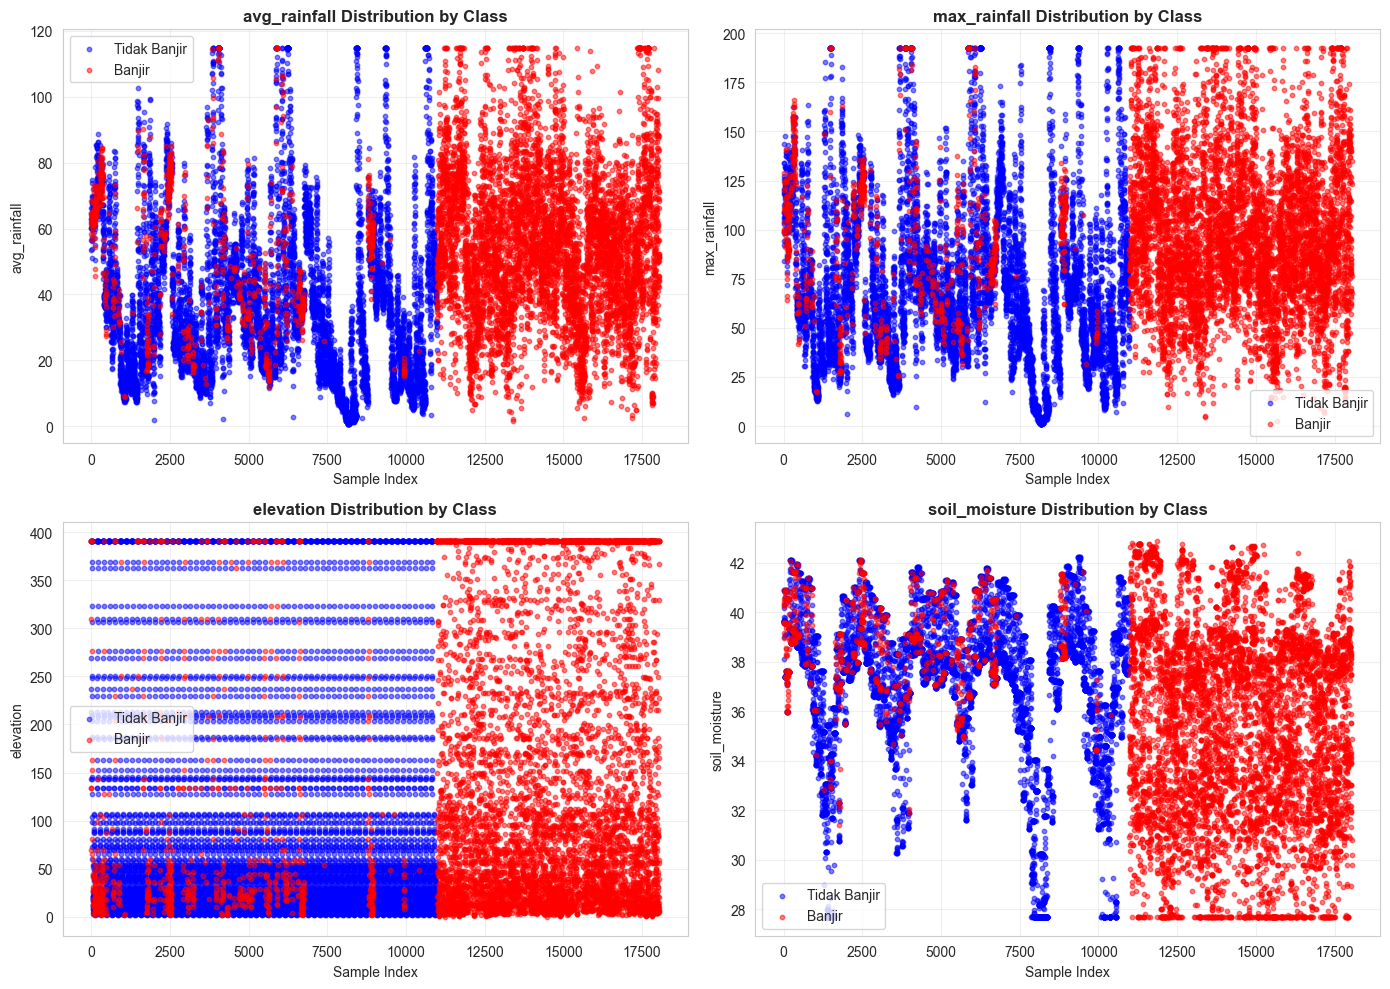

In [4]:
top_features = ['avg_rainfall', 'max_rainfall', 'elevation', 'soil_moisture']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = {0: 'blue', 1: 'red'}
labels = {0: 'Tidak Banjir', 1: 'Banjir'}

for idx, feat in enumerate(top_features):
    for label in [0, 1]:
        mask = y == label
        axes[idx].scatter(df[mask].index, df[mask][feat], 
                         c=colors[label], label=labels[label], 
                         alpha=0.5, s=10)
    
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel(feat)
    axes[idx].set_title(f'{feat} Distribution by Class', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

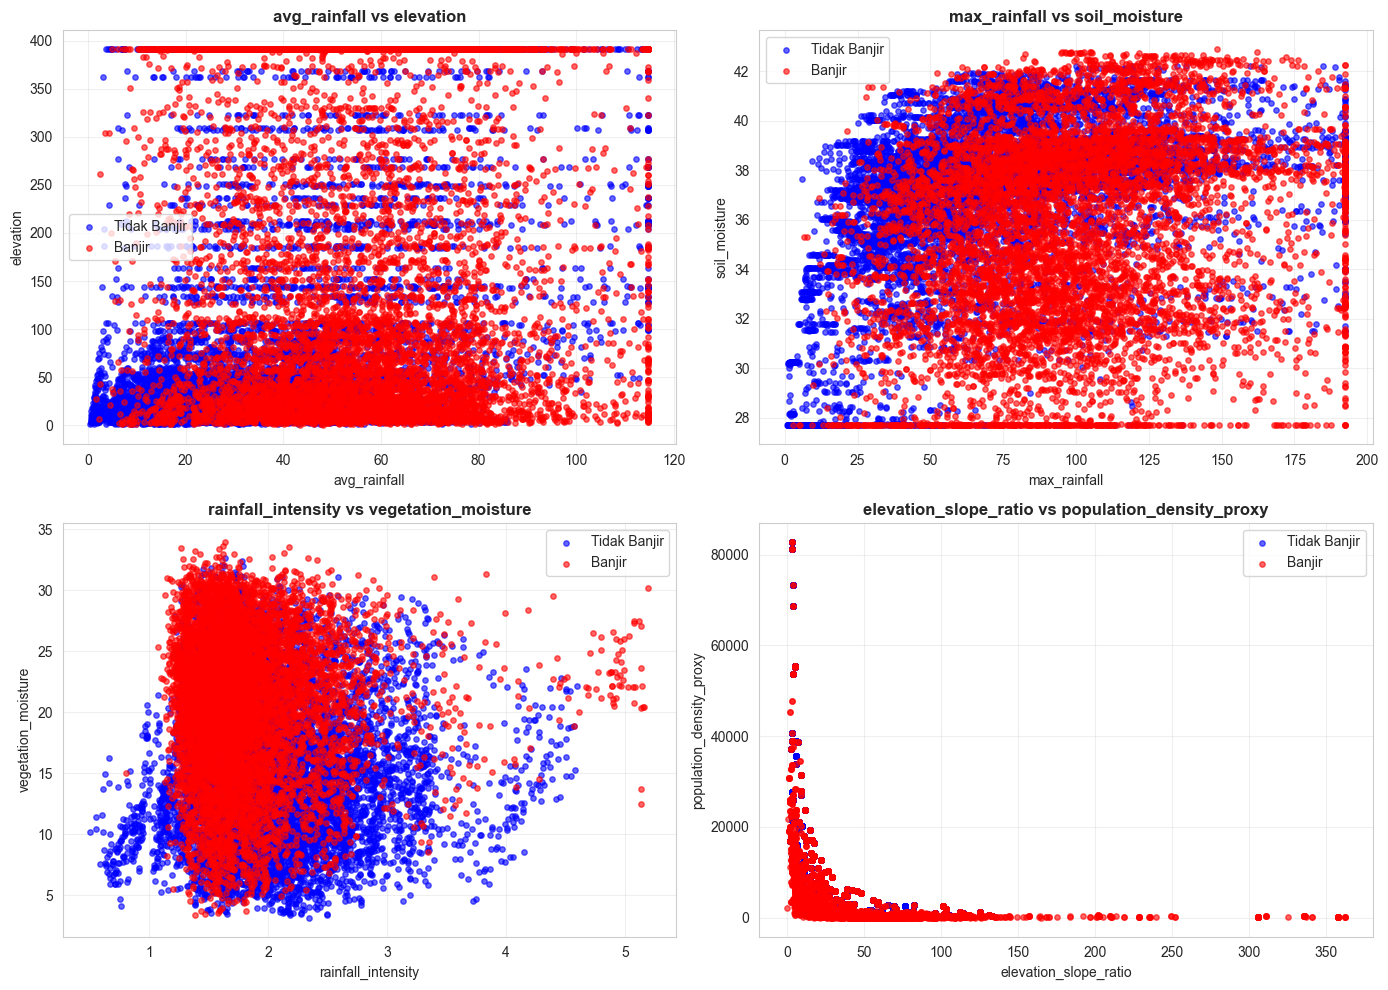

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

feature_pairs = [
    ('avg_rainfall', 'elevation'),
    ('max_rainfall', 'soil_moisture'),
    ('rainfall_intensity', 'vegetation_moisture'),
    ('elevation_slope_ratio', 'population_density_proxy')
]

for idx, (feat1, feat2) in enumerate(feature_pairs):
    for label in [0, 1]:
        mask = y == label
        axes[idx].scatter(df[mask][feat1], df[mask][feat2], 
                         c=colors[label], label=labels[label], 
                         alpha=0.6, s=15)
    
    axes[idx].set_xlabel(feat1)
    axes[idx].set_ylabel(feat2)
    axes[idx].set_title(f'{feat1} vs {feat2}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Train-Test Split

Stratified split untuk menjaga proporsi kelas

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train-Test Split:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print(f"\nTrain class distribution:")
print(y_train.value_counts())
print(f"\nTrain class balance:")
print(y_train.value_counts(normalize=True) * 100)

print(f"\nTest class distribution:")
print(y_test.value_counts())
print(f"\nTest class balance:")
print(y_test.value_counts(normalize=True) * 100)

Train-Test Split:
X_train: (14432, 16)
X_test: (3608, 16)
y_train: (14432,)
y_test: (3608,)

Train class distribution:
banjir
0    8108
1    6324
Name: count, dtype: int64

Train class balance:
banjir
0    56.18071
1    43.81929
Name: proportion, dtype: float64

Test class distribution:
banjir
0    2027
1    1581
Name: count, dtype: int64

Test class balance:
banjir
0    56.18071
1    43.81929
Name: proportion, dtype: float64


## 5. Train Decision Tree (Baseline)

Train dengan default parameters + class_weight balanced

In [7]:
dt_baseline = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

dt_baseline.fit(X_train, y_train)

y_pred_train = dt_baseline.predict(X_train)
y_pred_test = dt_baseline.predict(X_test)

print("Baseline Decision Tree Performance:")
print("=" * 60)
print(f"\nTrain Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"\nTree Depth: {dt_baseline.get_depth()}")
print(f"Number of Leaves: {dt_baseline.get_n_leaves()}")

Baseline Decision Tree Performance:

Train Accuracy: 1.0000
Test Accuracy: 0.9304

Tree Depth: 26
Number of Leaves: 739


## 6. Evaluate Model

Confusion matrix, classification report, dan metrics

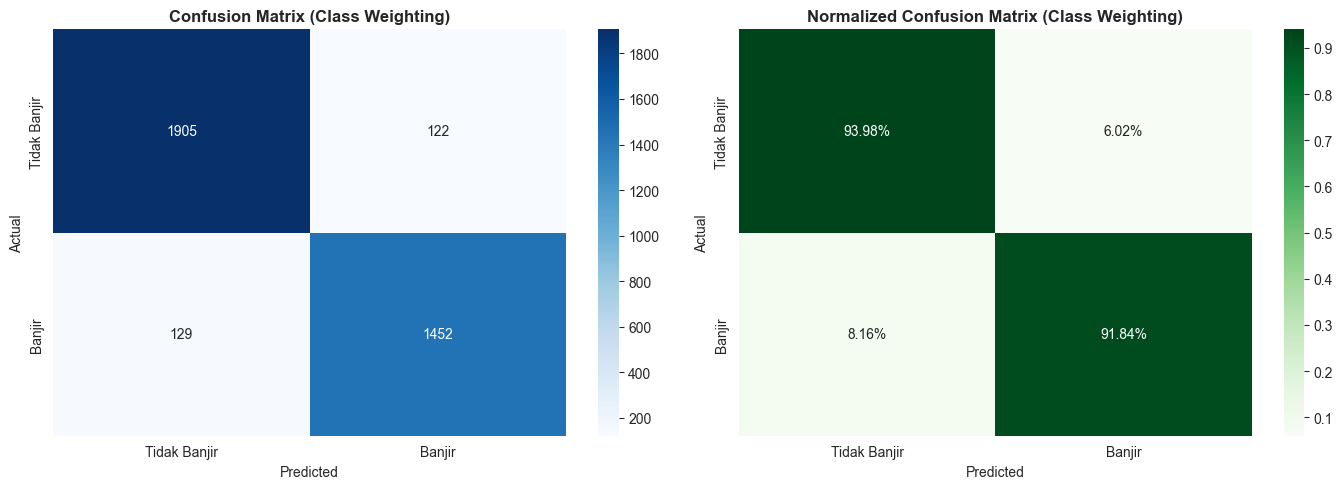


Classification Report:
              precision    recall  f1-score   support

Tidak Banjir       0.94      0.94      0.94      2027
      Banjir       0.92      0.92      0.92      1581

    accuracy                           0.93      3608
   macro avg       0.93      0.93      0.93      3608
weighted avg       0.93      0.93      0.93      3608



In [8]:
cm = confusion_matrix(y_test, y_pred_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tidak Banjir', 'Banjir'],
            yticklabels=['Tidak Banjir', 'Banjir'],
            ax=axes[0])
axes[0].set_title('Confusion Matrix (Class Weighting)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=['Tidak Banjir', 'Banjir'],
            yticklabels=['Tidak Banjir', 'Banjir'],
            ax=axes[1])
axes[1].set_title('Normalized Confusion Matrix (Class Weighting)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred_test, 
                          target_names=['Tidak Banjir', 'Banjir']))

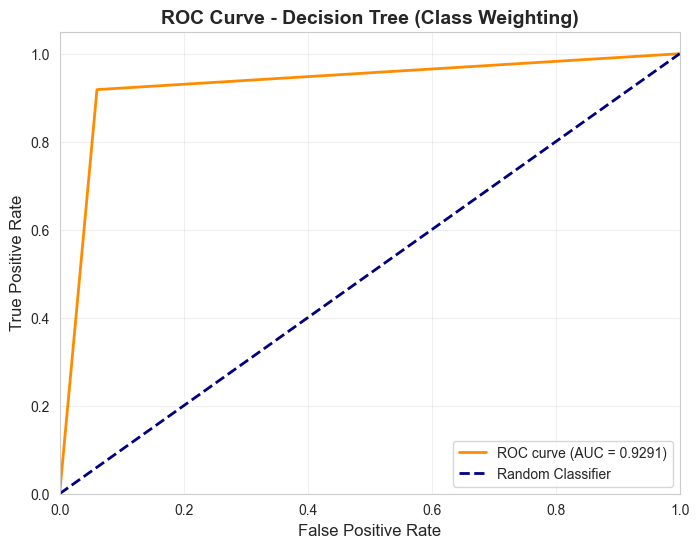

AUC-ROC Score: 0.9291


In [9]:
y_pred_proba = dt_baseline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Decision Tree (Class Weighting)', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC-ROC Score: {roc_auc:.4f}")

## 7. Entropy & Gini Index Analysis

Hitung entropy dan gini untuk root node dan beberapa splits

In [10]:
def calculate_entropy(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))
    return entropy

def calculate_gini(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    gini = 1 - np.sum(probabilities ** 2)
    return gini

print("Impurity Measures:")
print("=" * 60)

entropy_train = calculate_entropy(y_train)
gini_train = calculate_gini(y_train)

print(f"\nRoot Node (Training Data):")
print(f"  Entropy: {entropy_train:.4f}")
print(f"  Gini Index: {gini_train:.4f}")
print(f"  Samples: {len(y_train)}")
print(f"  Class 0: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"  Class 1: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")

tree = dt_baseline.tree_
n_nodes = tree.node_count
impurities = tree.impurity
samples = tree.n_node_samples

print(f"\nTree Statistics:")
print(f"  Total nodes: {n_nodes}")
print(f"  Average Gini per node: {np.mean(impurities):.4f}")
print(f"  Min Gini (purest node): {np.min(impurities):.4f}")
print(f"  Max Gini (most impure): {np.max(impurities):.4f}")

Impurity Measures:

Root Node (Training Data):
  Entropy: 0.9889
  Gini Index: 0.4924
  Samples: 14432
  Class 0: 8108 (56.18%)
  Class 1: 6324 (43.82%)

Tree Statistics:
  Total nodes: 1477
  Average Gini per node: 0.1286
  Min Gini (purest node): -0.0000
  Max Gini (most impure): 0.5000


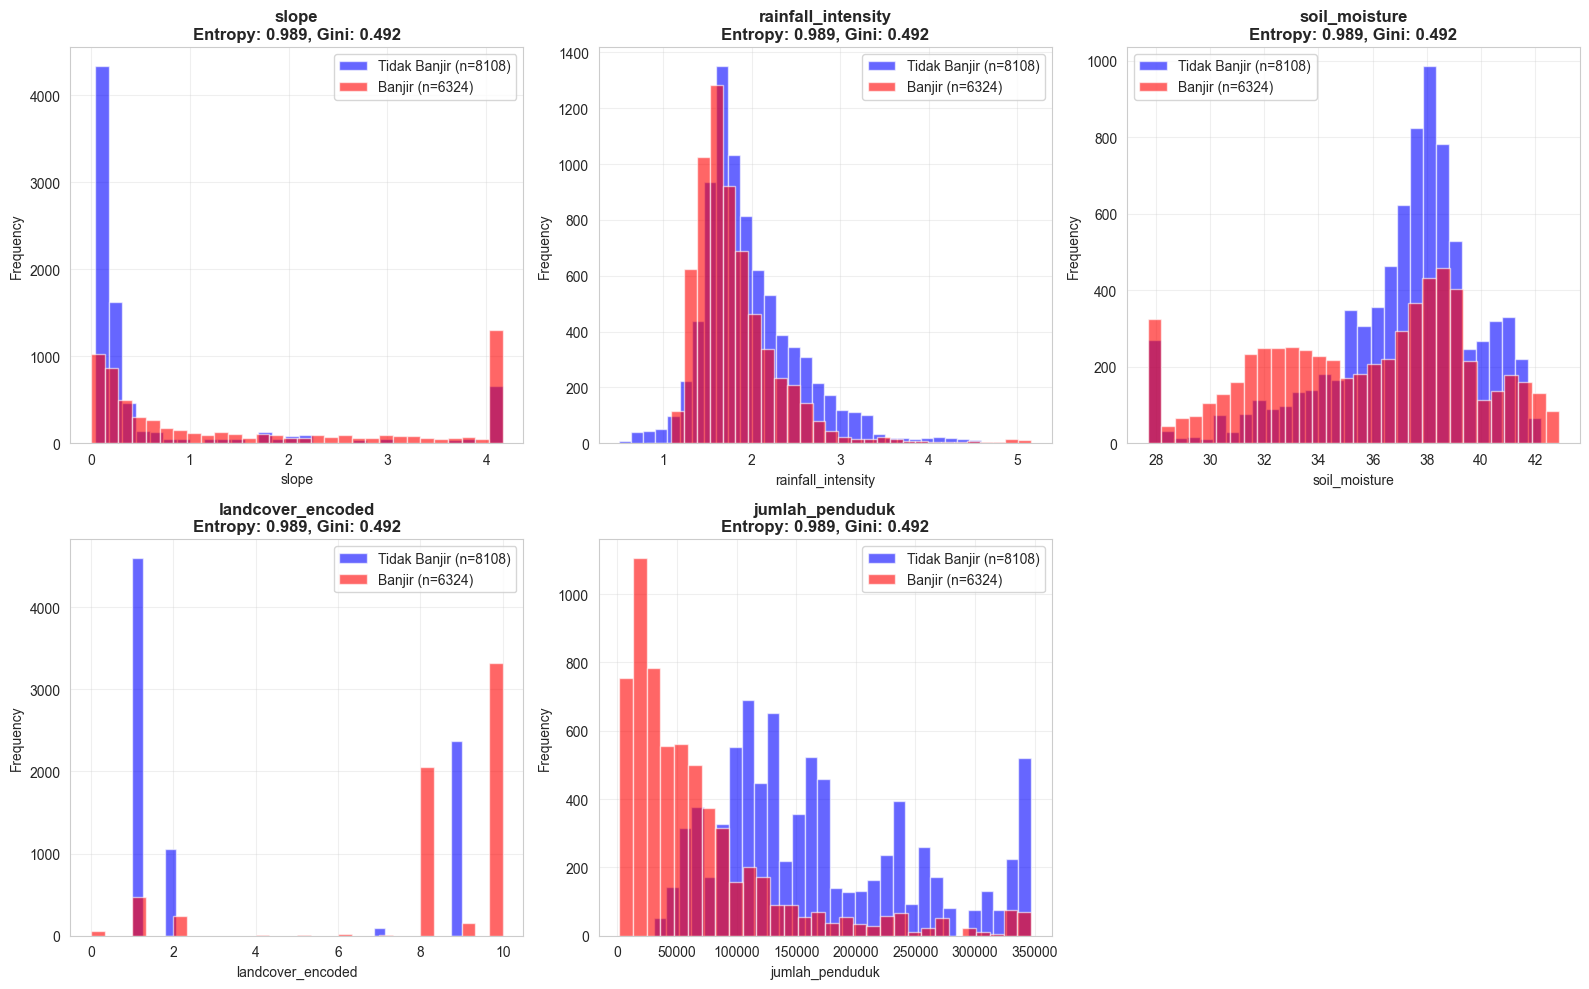

In [11]:
top_5_features = X_train.columns[np.argsort(dt_baseline.feature_importances_)[-5:]]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feat in enumerate(top_5_features):
    for label in [0, 1]:
        mask = y_train == label
        
        entropy_class = calculate_entropy(y_train[mask])
        gini_class = calculate_gini(y_train[mask])
        
        axes[idx].hist(X_train.loc[mask, feat], bins=30, alpha=0.6, 
                      label=f'{labels[label]} (n={mask.sum()})', 
                      color=colors[label])
    
    axes[idx].set_xlabel(feat)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{feat}\nEntropy: {calculate_entropy(y_train):.3f}, Gini: {calculate_gini(y_train):.3f}', 
                        fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

axes[5].axis('off')
plt.tight_layout()
plt.show()

## 8. Visualize Decision Tree Structure

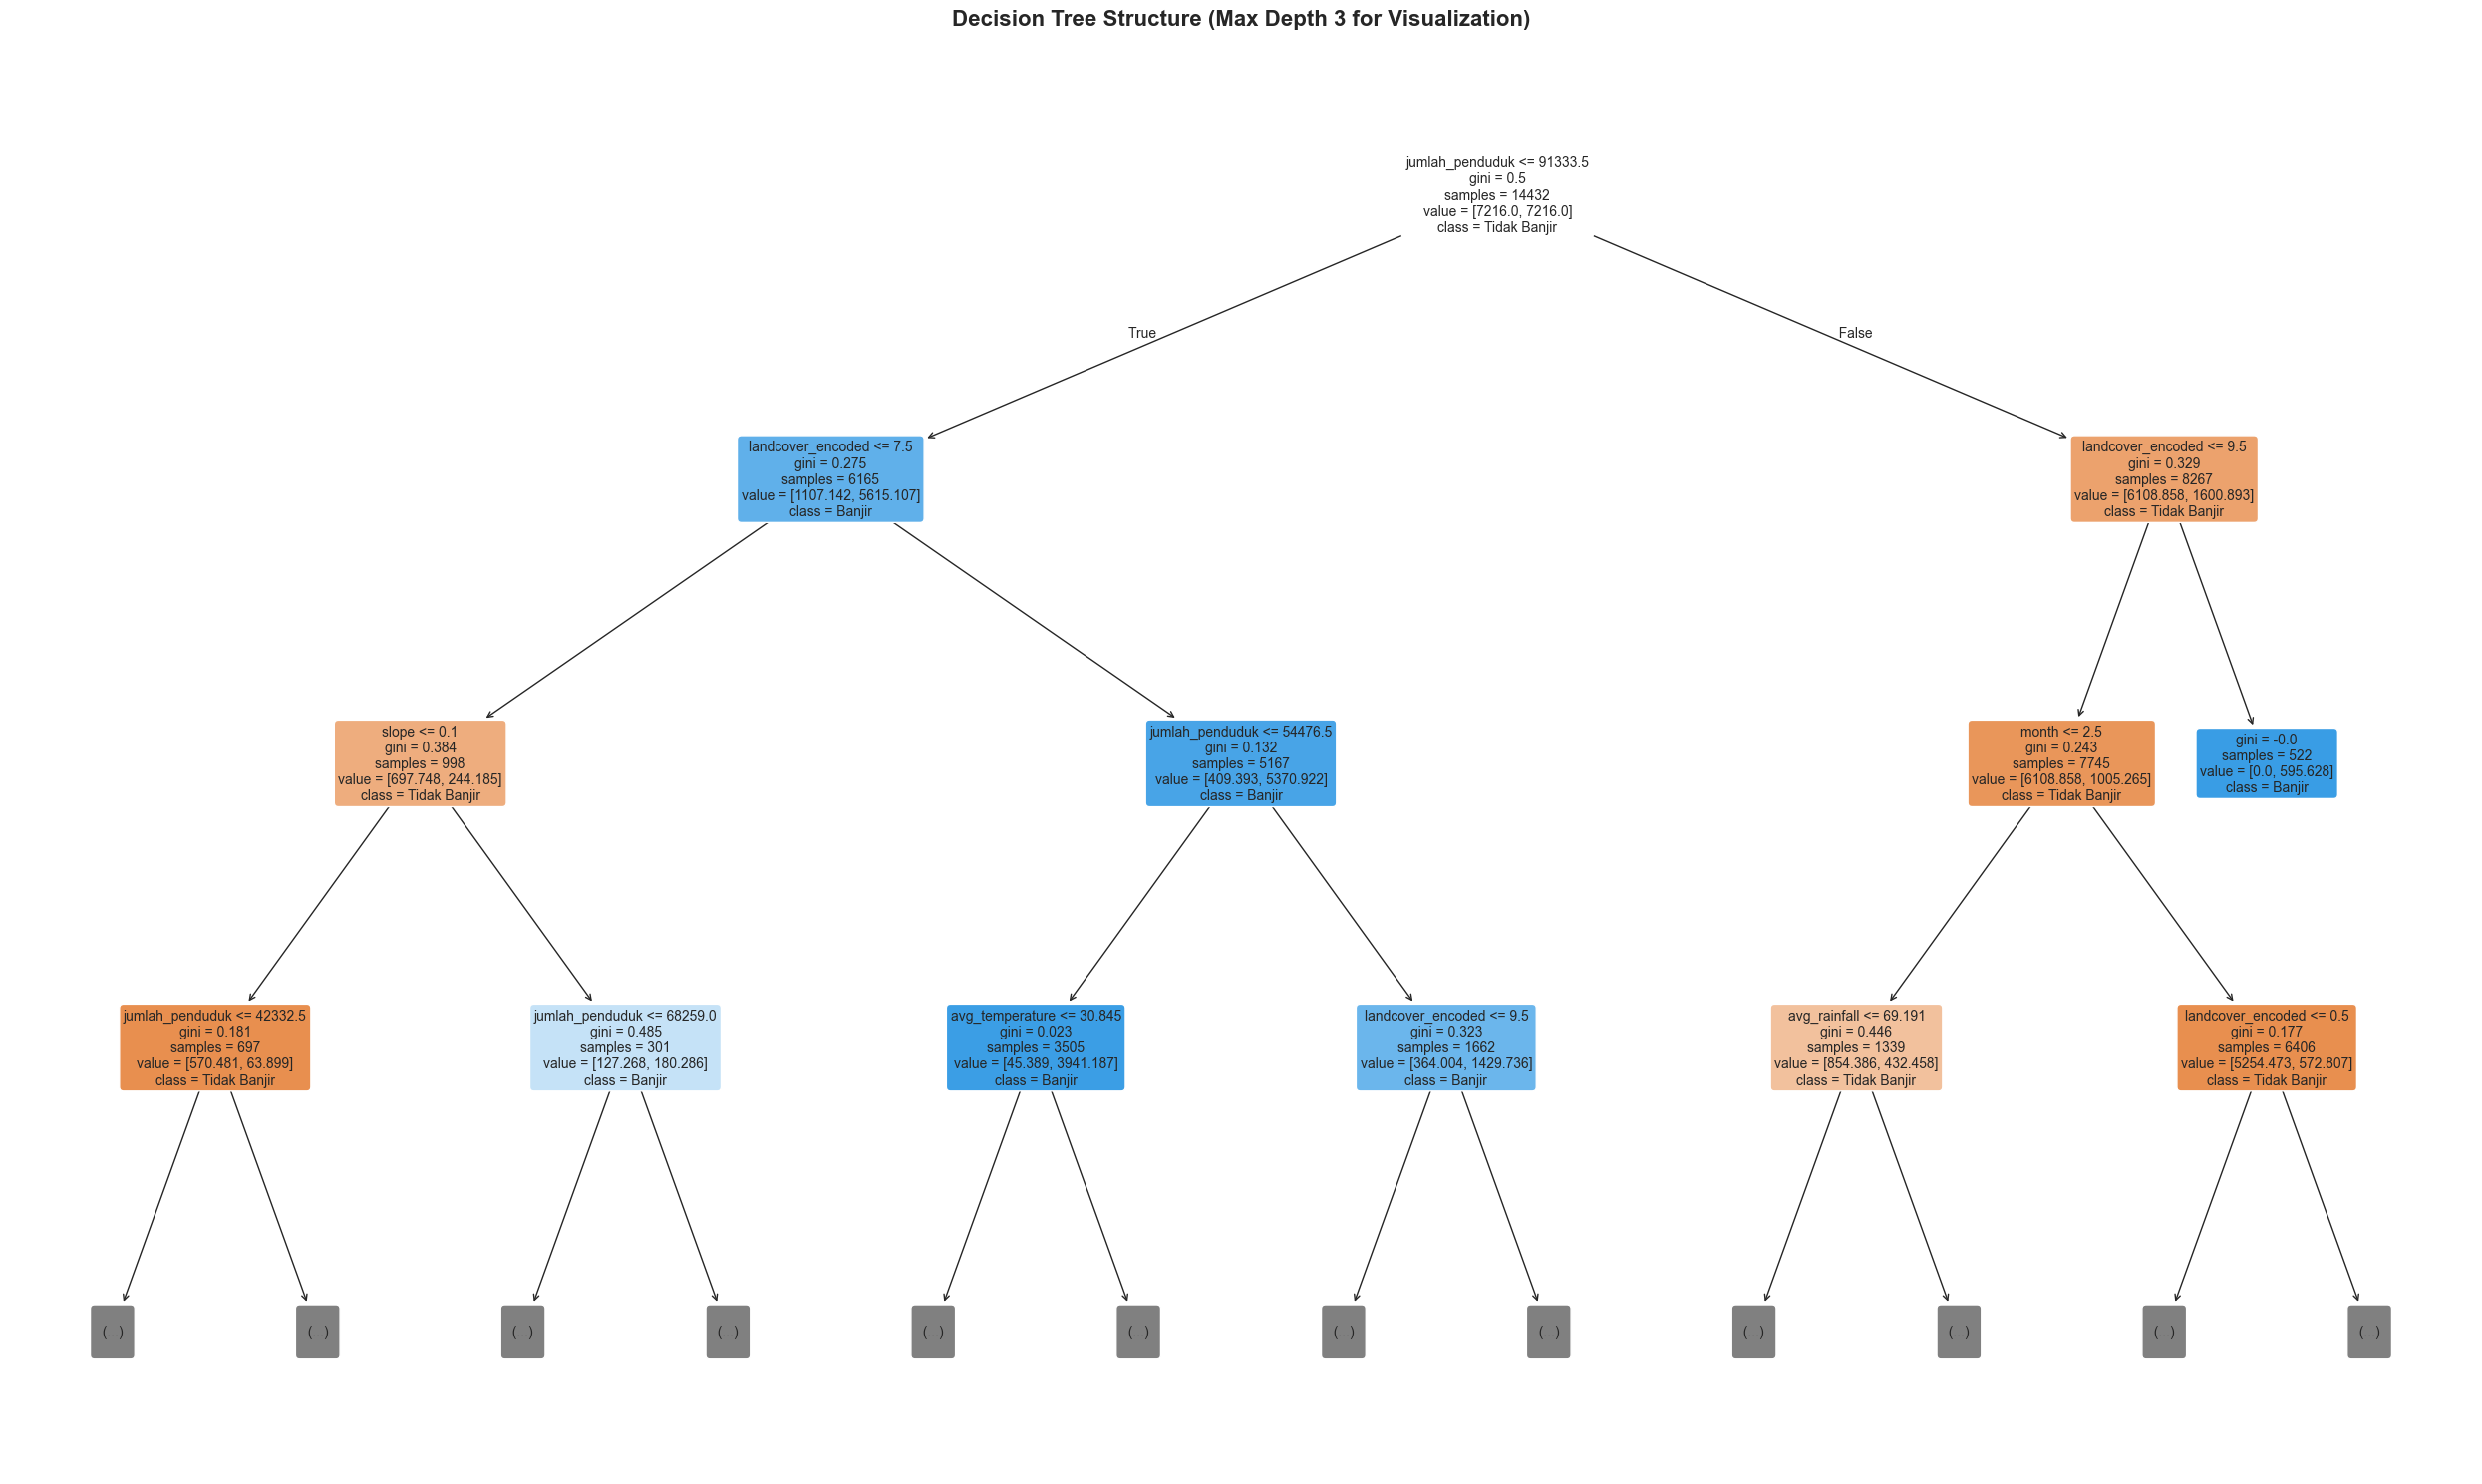

In [12]:
plt.figure(figsize=(25, 15))
plot_tree(dt_baseline, 
          feature_names=feature_columns,
          class_names=['Tidak Banjir', 'Banjir'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)
plt.title('Decision Tree Structure (Max Depth 3 for Visualization)', 
          fontweight='bold', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

Feature Importance (Top 15):
jumlah_penduduk                    : 0.4311
landcover_encoded                  : 0.3224
soil_moisture                      : 0.0320
rainfall_intensity                 : 0.0306
slope                              : 0.0304
month                              : 0.0277
avg_rainfall                       : 0.0271
avg_temperature                    : 0.0192
vegetation_moisture                : 0.0167
max_rainfall                       : 0.0159
ndvi                               : 0.0150
population_density_proxy           : 0.0147
elevation_slope_ratio              : 0.0126
elevation                          : 0.0030
is_rainy_season                    : 0.0014


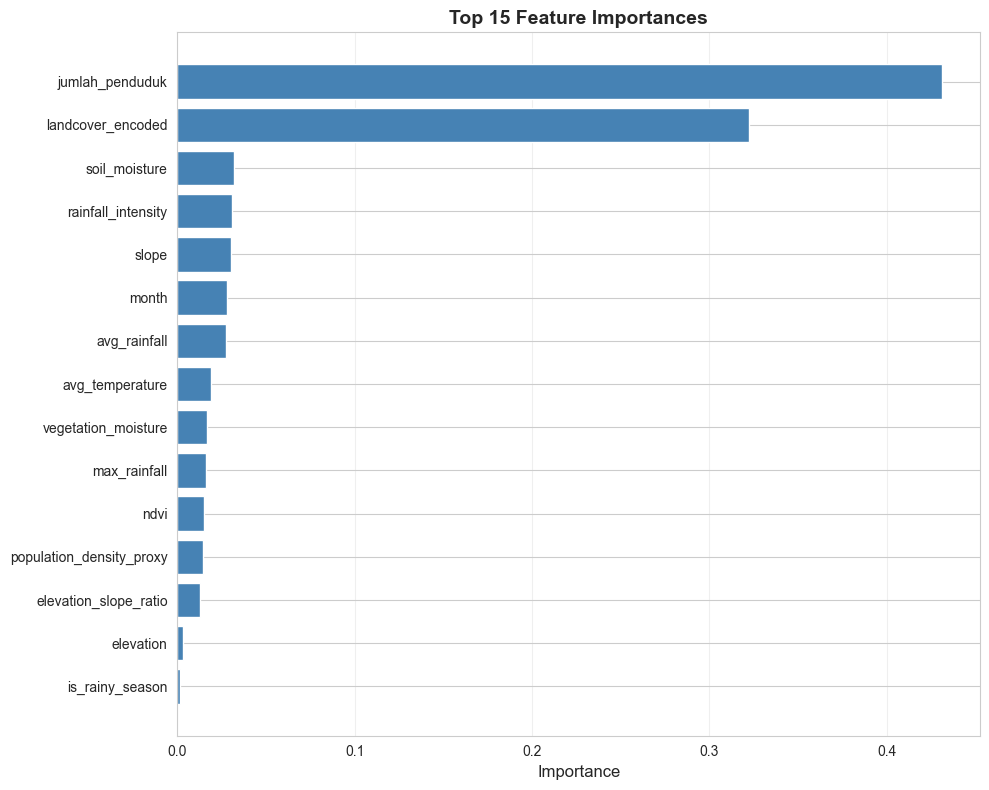

In [13]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': dt_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance (Top 15):")
print("=" * 60)
for idx, row in feature_importance.head(15).iterrows():
    print(f"{row['feature']:35s}: {row['importance']:.4f}")

plt.figure(figsize=(10, 8))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Feature Importances', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Pruning Analysis (Cost Complexity)

Mencari alpha optimal untuk pruning menggunakan cross-validation

Cost Complexity Pruning Analysis:
Number of alpha values: 400
Alpha range: 0.000000 to 0.196054


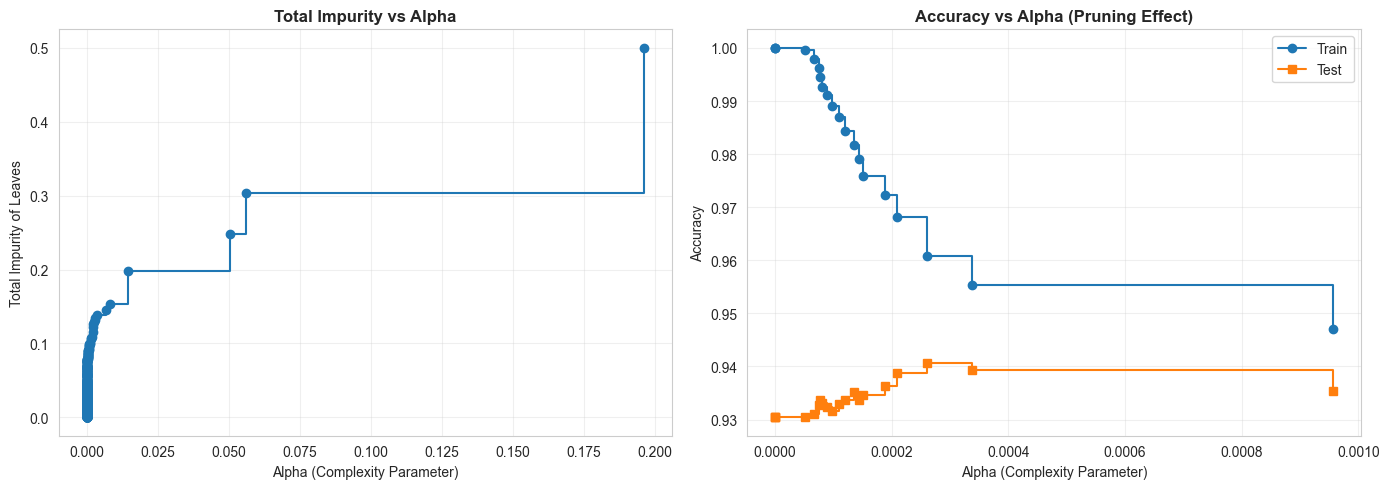


Best Alpha: 0.000260
Best Test Accuracy: 0.9407


In [14]:
path = dt_baseline.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
impurities = path.impurities

print("Cost Complexity Pruning Analysis:")
print("=" * 60)
print(f"Number of alpha values: {len(ccp_alphas)}")
print(f"Alpha range: {ccp_alphas.min():.6f} to {ccp_alphas.max():.6f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(ccp_alphas, impurities, marker='o', drawstyle="steps-post")
axes[0].set_xlabel('Alpha (Complexity Parameter)')
axes[0].set_ylabel('Total Impurity of Leaves')
axes[0].set_title('Total Impurity vs Alpha', fontweight='bold')
axes[0].grid(alpha=0.3)

clfs = []
train_scores = []
test_scores = []

for ccp_alpha in ccp_alphas[::max(1, len(ccp_alphas)//20)]:
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

axes[1].plot(ccp_alphas[::max(1, len(ccp_alphas)//20)], train_scores, 
             marker='o', label='Train', drawstyle="steps-post")
axes[1].plot(ccp_alphas[::max(1, len(ccp_alphas)//20)], test_scores, 
             marker='s', label='Test', drawstyle="steps-post")
axes[1].set_xlabel('Alpha (Complexity Parameter)')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs Alpha (Pruning Effect)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

best_idx = np.argmax(test_scores)
best_alpha = ccp_alphas[::max(1, len(ccp_alphas)//20)][best_idx]
best_test_acc = test_scores[best_idx]

print(f"\nBest Alpha: {best_alpha:.6f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")

## 11. Train Optimized (Pruned) Tree

In [15]:
dt_pruned = DecisionTreeClassifier(
    ccp_alpha=best_alpha,
    class_weight='balanced',
    random_state=42
)

dt_pruned.fit(X_train, y_train)

y_pred_pruned_train = dt_pruned.predict(X_train)
y_pred_pruned_test = dt_pruned.predict(X_test)

print("Pruned Decision Tree Performance:")
print("=" * 60)
print(f"\nTrain Accuracy: {accuracy_score(y_train, y_pred_pruned_train):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_pruned_test):.4f}")
print(f"\nTree Depth: {dt_pruned.get_depth()}")
print(f"Number of Leaves: {dt_pruned.get_n_leaves()}")

print("\n" + "=" * 60)
print("COMPARISON: Baseline vs Pruned")
print("=" * 60)
print(f"{'Metric':<25} {'Baseline':>12} {'Pruned':>12} {'Change':>12}")
print("-" * 60)
print(f"{'Train Accuracy':<25} {accuracy_score(y_train, y_pred_train):>12.4f} {accuracy_score(y_train, y_pred_pruned_train):>12.4f} {accuracy_score(y_train, y_pred_pruned_train) - accuracy_score(y_train, y_pred_train):>12.4f}")
print(f"{'Test Accuracy':<25} {accuracy_score(y_test, y_pred_test):>12.4f} {accuracy_score(y_test, y_pred_pruned_test):>12.4f} {accuracy_score(y_test, y_pred_pruned_test) - accuracy_score(y_test, y_pred_test):>12.4f}")
print(f"{'Tree Depth':<25} {dt_baseline.get_depth():>12} {dt_pruned.get_depth():>12} {dt_pruned.get_depth() - dt_baseline.get_depth():>12}")
print(f"{'Number of Leaves':<25} {dt_baseline.get_n_leaves():>12} {dt_pruned.get_n_leaves():>12} {dt_pruned.get_n_leaves() - dt_baseline.get_n_leaves():>12}")

Pruned Decision Tree Performance:

Train Accuracy: 0.9609
Test Accuracy: 0.9407

Tree Depth: 15
Number of Leaves: 98

COMPARISON: Baseline vs Pruned
Metric                        Baseline       Pruned       Change
------------------------------------------------------------
Train Accuracy                  1.0000       0.9609      -0.0391
Test Accuracy                   0.9304       0.9407       0.0103
Tree Depth                          26           15          -11
Number of Leaves                   739           98         -641


## 12. Hyperparameter Tuning with GridSearch

Mencari kombinasi parameter terbaik

In [16]:
param_grid = {
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

dt_grid = DecisionTreeClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(
    dt_grid, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Running GridSearchCV...")
print("This may take a few minutes...")
grid_search.fit(X_train, y_train)

print("\nBest Parameters:")
print("=" * 60)
for param, value in grid_search.best_params_.items():
    print(f"{param:25s}: {value}")

print(f"\nBest CV Score: {grid_search.best_score_:.4f}")

dt_best = grid_search.best_estimator_
y_pred_best = dt_best.predict(X_test)

print(f"\nBest Model Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"Tree Depth: {dt_best.get_depth()}")
print(f"Number of Leaves: {dt_best.get_n_leaves()}")

Running GridSearchCV...
This may take a few minutes...
Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best Parameters:
criterion                : entropy
max_depth                : 10
min_samples_leaf         : 1
min_samples_split        : 20

Best CV Score: 0.9430

Best Model Test Accuracy: 0.9393
Tree Depth: 10
Number of Leaves: 92


## 13. Extract Decision Rules

Export tree rules dalam format text

In [17]:
tree_rules = export_text(dt_best, feature_names=feature_columns)

print("Decision Tree Rules (Best Model):")
print("=" * 80)
print(tree_rules[:2000])
print("\n... (truncated for display, full tree saved to file)")

with open('decision_tree_rules.txt', 'w') as f:
    f.write("Decision Tree Rules - Flood Prediction\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Model Parameters:\n")
    f.write(f"  Criterion: {dt_best.criterion}\n")
    f.write(f"  Max Depth: {dt_best.max_depth}\n")
    f.write(f"  Min Samples Split: {dt_best.min_samples_split}\n")
    f.write(f"  Min Samples Leaf: {dt_best.min_samples_leaf}\n")
    f.write(f"  Tree Depth: {dt_best.get_depth()}\n")
    f.write(f"  Number of Leaves: {dt_best.get_n_leaves()}\n")
    f.write(f"  Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}\n\n")
    f.write("=" * 80 + "\n\n")
    f.write(tree_rules)

print("\nFull rules saved to: decision_tree_rules.txt")

Decision Tree Rules (Best Model):
|--- landcover_encoded <= 9.50
|   |--- jumlah_penduduk <= 54062.50
|   |   |--- population_density_proxy <= 6647.90
|   |   |   |--- landcover_encoded <= 8.50
|   |   |   |   |--- avg_rainfall <= 3.40
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- avg_rainfall >  3.40
|   |   |   |   |   |--- class: 1
|   |   |   |--- landcover_encoded >  8.50
|   |   |   |   |--- soil_moisture <= 39.45
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- soil_moisture >  39.45
|   |   |   |   |   |--- class: 1
|   |   |--- population_density_proxy >  6647.90
|   |   |   |--- jumlah_penduduk <= 46255.00
|   |   |   |   |--- vegetation_moisture <= 7.63
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- vegetation_moisture >  7.63
|   |   |   |   |   |--- month <= 6.50
|   |   |   |   |   |   |--- ndvi <= 0.44
|   |   |   |   |   |   |   |--- rainfall_intensity <= 2.51
|   |   |   |   |   |   |   |   |--- max_rainfall <= 46.04
|   |   |   |   |   |   |   |

## 14. Visualize Best Model Tree

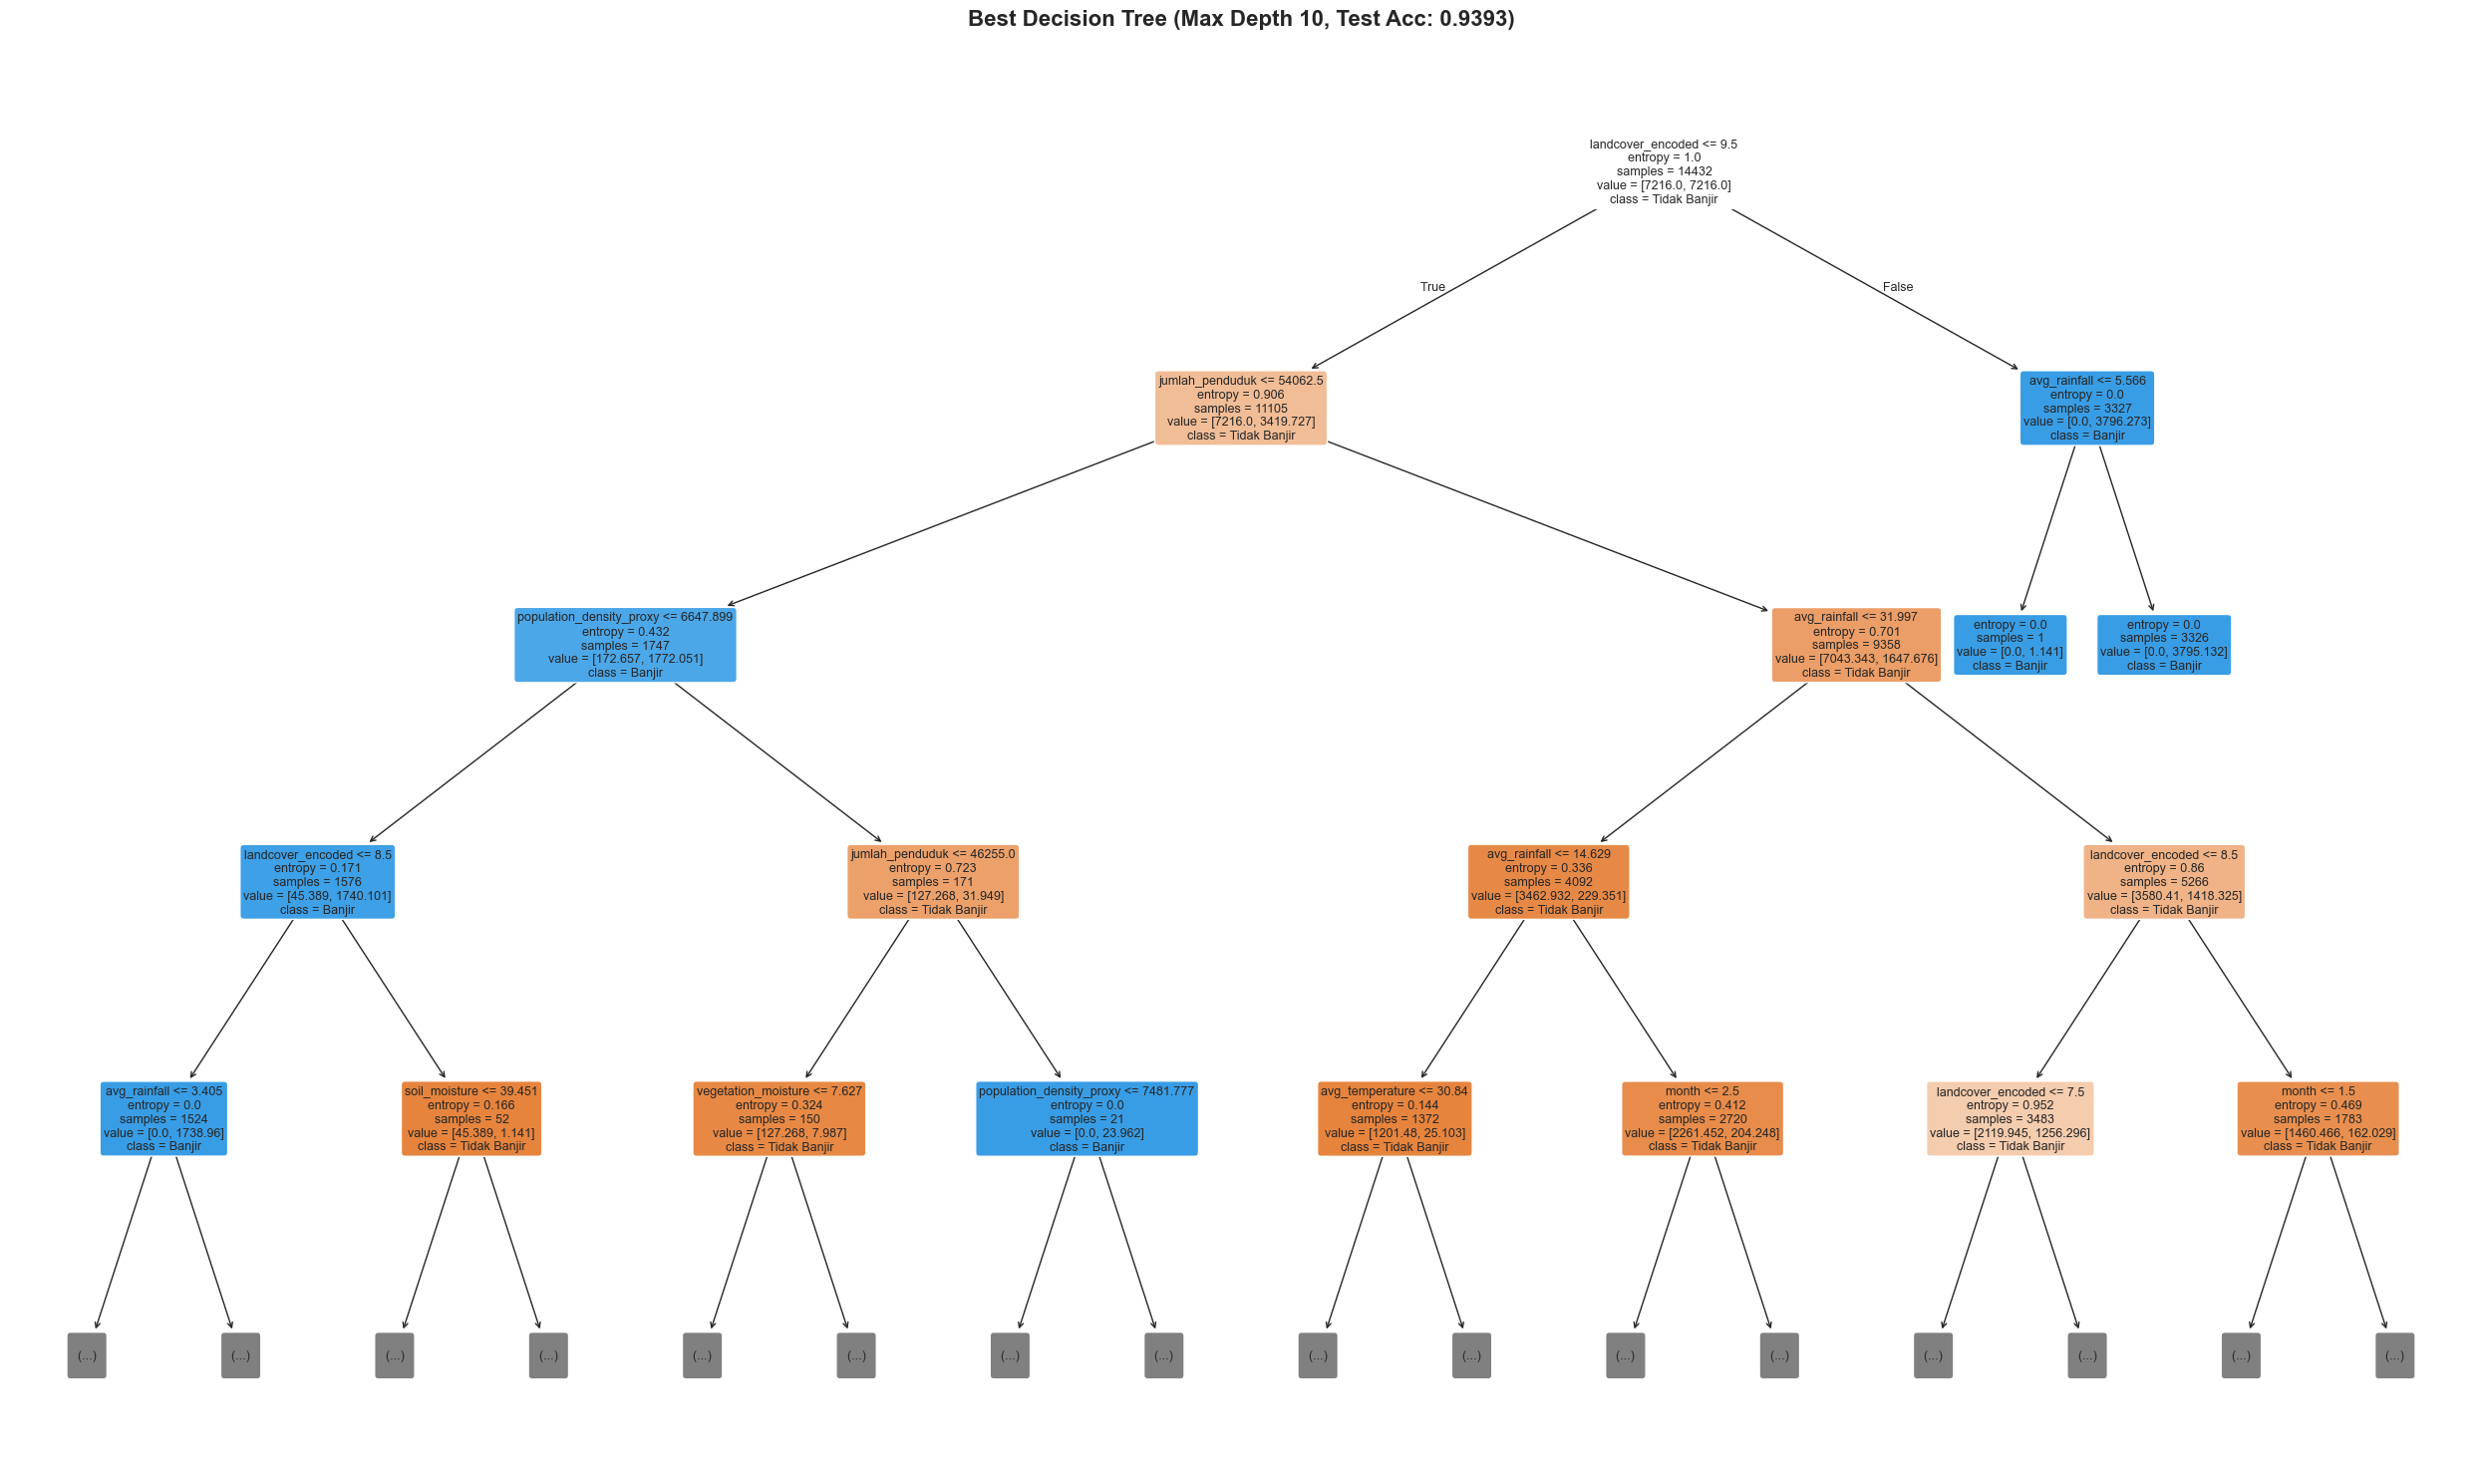

Tree visualization saved to: decision_tree_visualization.png


In [18]:
plt.figure(figsize=(25, 15))
plot_tree(dt_best, 
          feature_names=feature_columns,
          class_names=['Tidak Banjir', 'Banjir'],
          filled=True,
          rounded=True,
          fontsize=9,
          max_depth=4)
plt.title(f'Best Decision Tree (Max Depth {dt_best.max_depth}, Test Acc: {accuracy_score(y_test, y_pred_best):.4f})', 
          fontweight='bold', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('decision_tree_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Tree visualization saved to: decision_tree_visualization.png")

## 15. Final Model Evaluation

In [19]:
print("=" * 80)
print("FINAL MODEL SUMMARY - BEST DECISION TREE")
print("=" * 80)

print("\nModel Configuration:")
print(f"  Algorithm: Decision Tree Classifier")
print(f"  Criterion: {dt_best.criterion}")
print(f"  Max Depth: {dt_best.max_depth}")
print(f"  Min Samples Split: {dt_best.min_samples_split}")
print(f"  Min Samples Leaf: {dt_best.min_samples_leaf}")
print(f"  Class Weight: balanced")

print("\nTree Structure:")
print(f"  Total Depth: {dt_best.get_depth()}")
print(f"  Number of Leaves: {dt_best.get_n_leaves()}")
print(f"  Total Nodes: {dt_best.tree_.node_count}")

print("\nPerformance Metrics:")
print(f"  Train Accuracy: {accuracy_score(y_train, dt_best.predict(X_train)):.4f}")
print(f"  Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_best):.4f}")
print(f"  Recall: {recall_score(y_test, y_pred_best):.4f}")
print(f"  F1-Score: {f1_score(y_test, y_pred_best):.4f}")
print(f"  AUC-ROC: {roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]):.4f}")

print("\nTop 5 Most Important Features:")
feature_imp_best = pd.DataFrame({
    'feature': feature_columns,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False)

for idx, row in feature_imp_best.head(5).iterrows():
    print(f"  {row['feature']:35s}: {row['importance']:.4f}")

print("\n" + "=" * 80)
print("Model training completed successfully!")
print("Output files generated:")
print("  - decision_tree_rules.txt")
print("  - decision_tree_visualization.png")
print("=" * 80)

FINAL MODEL SUMMARY - BEST DECISION TREE

Model Configuration:
  Algorithm: Decision Tree Classifier
  Criterion: entropy
  Max Depth: 10
  Min Samples Split: 20
  Min Samples Leaf: 1
  Class Weight: balanced

Tree Structure:
  Total Depth: 10
  Number of Leaves: 92
  Total Nodes: 183

Performance Metrics:
  Train Accuracy: 0.9538
  Test Accuracy: 0.9393
  Precision: 0.9664
  Recall: 0.8925
  F1-Score: 0.9280
  AUC-ROC: 0.9725

Top 5 Most Important Features:
  landcover_encoded                  : 0.5794
  jumlah_penduduk                    : 0.2445
  avg_rainfall                       : 0.0641
  population_density_proxy           : 0.0382
  month                              : 0.0166

Model training completed successfully!
Output files generated:
  - decision_tree_rules.txt
  - decision_tree_visualization.png
